The minimum key attributes for your project are:
Close , Return , Volume , Rolling Mean , and Volatility .
Using S&P 500 data is feasible, but start with a subset of 5–10 stocks and 5–10 years of data for simplicity. Handle NaN values using forward fill, backward fill, or interpolation.


We select key attribute for 10years/stock to make small portfolio(10 stock)

predict over 10 days

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from ta.momentum import RSIIndicator  # For calculating RSI

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam


In [2]:


# Load data
data = yf.download('MSFT', start='2003-10-05', end='2024-01-02')
# data = pd.read_csv('TSLA_19_24.csv')

# Basic features --------------------------------
df = data[['Close']].copy()

# Rolling 
df['Rolling_Mean_5'] = df['Close'].rolling(5).mean()


# MACD (12, 26, 9)
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
# df['MACD'] = df['EMA_12'] - df['EMA_26']
# df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands (20, 2)
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['Upper_Band'] = df['Close'].rolling(window=20).mean() + (df['Close'].rolling(window=20).std() * 2)
df['Lower_Band'] = df['Close'].rolling(window=20).mean() - (df['Close'].rolling(window=20).std() * 2)


# Drop rows with NaN values introduced by calculations
df.dropna(inplace=True)

# Display the first few rows of the enhanced dataset
df.info()



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5075 entries, 2003-10-31 to 2023-12-29
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Close, MSFT)       5075 non-null   float64
 1   (Rolling_Mean_5, )  5075 non-null   float64
 2   (EMA_12, )          5075 non-null   float64
 3   (EMA_26, )          5075 non-null   float64
 4   (SMA_20, )          5075 non-null   float64
 5   (Upper_Band, )      5075 non-null   float64
 6   (Lower_Band, )      5075 non-null   float64
dtypes: float64(7)
memory usage: 317.2 KB


In [3]:
df.corr(numeric_only=True)

,Price,Close,Rolling_Mean_5,EMA_12,EMA_26,SMA_20,Upper_Band,Lower_Band
,Ticker,MSFT,,,,,,
Price,Ticker,,,,,,,
Close,MSFT,1.000000,0.999730,0.999492,0.998891,0.998801,0.998446,0.998222
Rolling_Mean_5,,0.999730,1.000000,0.999845,0.999332,0.999282,0.998909,0.998722
EMA_12,,0.999492,0.999845,1.000000,0.999780,0.999780,0.999393,0.999235
EMA_26,,0.998891,0.999332,0.999780,1.000000,0.999919,0.999592,0.999308
SMA_20,,0.998801,0.999282,0.999780,0.999919,1.000000,0.999587,0.999485
Upper_Band,,0.998446,0.998909,0.999393,0.999592,0.999587,1.000000,0.998149
Lower_Band,,0.998222,0.998722,0.999235,0.999308,0.999485,0.998149,1.000000


# Data preprocessing

In [4]:


numerical_features = ['Close', 'Rolling_Mean_5', 'EMA_12', 'EMA_26','SMA_20', 'Upper_Band','Lower_Band']
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Define target for 10-day prediction
df['Target_10_Days'] = df['Close'].shift(-30)

# Drop rows with NaN values introduced by shifting
df.dropna(inplace=True)

# Time Series Split for 10-day prediction
split_index = int(len(df) * 0.8)
train_df = df[:split_index]
test_df = df[split_index:]


print(f"10-Day Prediction - Training set size: {len(train_df)}")
print(f"10-Day Prediction - Testing set size: {len(test_df)}")


10-Day Prediction - Training set size: 4036
10-Day Prediction - Testing set size: 1009


# save train test

In [5]:
# Save or inspect
train_df.to_csv('MSFT_train.csv', index=False)
test_df.to_csv('MSFT_test.csv', index=False)

# create sequence 

In [6]:
# Function to create sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])  # Exclude the target column
        y.append(data[i + time_steps, -1])      # Target column
    return np.array(X), np.array(y)


# Define time steps (input)
time_steps = 60

# Create sequences for training and testing
X_train, y_train = create_sequences(train_df[numerical_features + ['Target_10_Days']].values, time_steps)
X_test, y_test = create_sequences(test_df[numerical_features + ['Target_10_Days']].values, time_steps)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Check data types
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")
print(f"X_test dtype: {X_test.dtype}")
print(f"y_test dtype: {y_test.dtype}")



X_train shape: (3976, 60, 7)
y_train shape: (3976,)
X_test shape: (949, 60, 7)
y_test shape: (949,)
X_train dtype: float64
y_train dtype: float64
X_test dtype: float64
y_test dtype: float64


# Normalize the data

In [7]:
# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


# LSTM MODEL BUILDING

In [8]:

# Build the LSTM model  64/0.1  96/0.2 256/0.3
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), kernel_regularizer='l2'))
model.add(Dropout(0.6))
model.add(LSTM(units=96, return_sequences=False, kernel_regularizer='l2'))
model.add(Dropout(0.6))
model.add(Dense(units=1))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


# Print the model summary
model.summary()

2025-05-12 23:44:02.584516: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-12 23:44:02.584559: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-12 23:44:02.584568: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-12 23:44:02.584600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-12 23:44:02.584625: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, pref

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 96)         │        39,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,145 (445.88 KB)

 Trainable params: 114,145 (445.88 KB)

 Non-trainable params: 0 (0.00 B)

# Model training

In [9]:

history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50


2025-05-12 23:44:03.542990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-12 23:44:03.545739: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 1.6932 - val_loss: 2.2326
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6588 - val_loss: 2.0297
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.6271 - val_loss: 1.8712
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.5982 - val_loss: 1.7585
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.5713 - val_loss: 1.6745
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.5441 - val_loss: 1.6206
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.5187 - val_loss: 1.5691
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.4931 - val_loss: 1.5288
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.4679 - val_loss: 1.4855
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.4434 - val_loss: 1.4547
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.4192 - val_loss: 1.4198
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.3953 - val_l

# Model visualize & evaluation

In [10]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')



30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6965
Test Loss: 0.6984312534332275


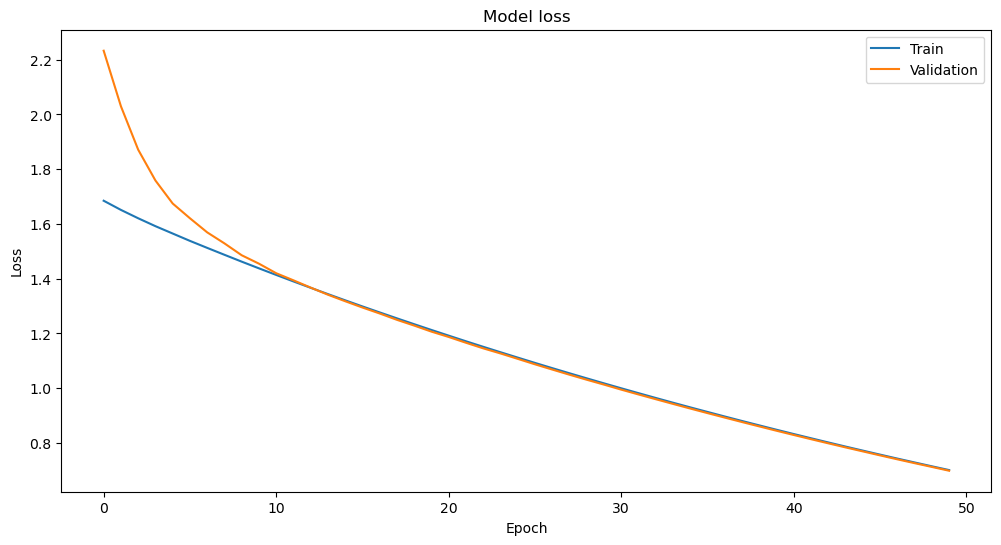

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

20/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2025-05-12 23:45:31.713390: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


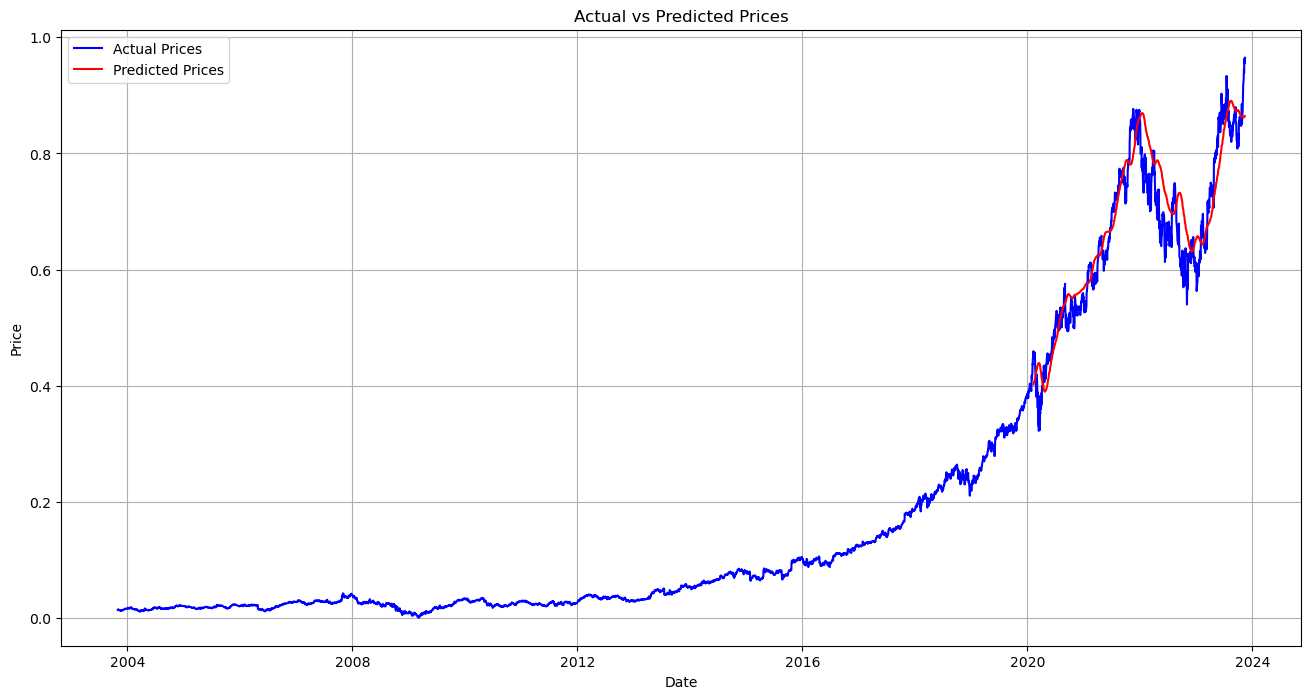

In [12]:
# Make predictions
predictions = model.predict(X_test)

# Get the last close values for the test set

last_close_values_test = test_df.index[time_steps-1:len(X_test) + time_steps - 1]

# Plot the predictions vs actual values
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Actual Prices' ,color='blue')
plt.plot(last_close_values_test, predictions.flatten(), label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()



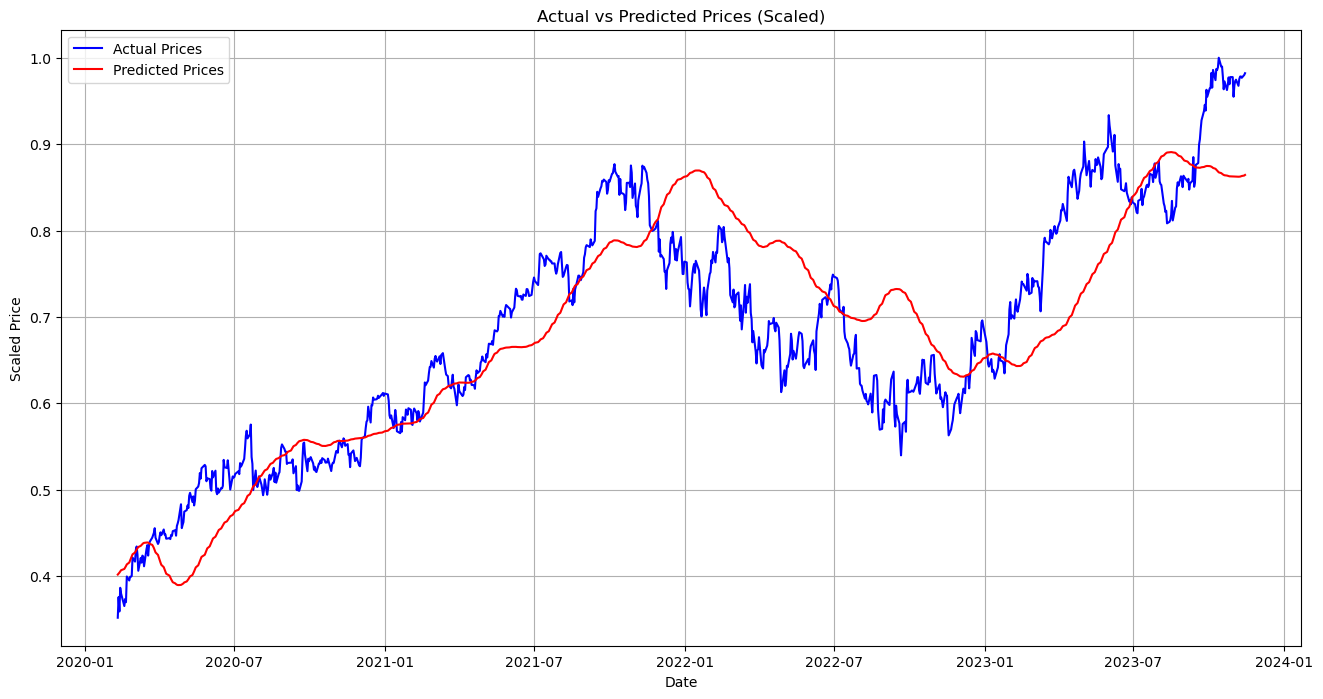

In [47]:
last_close_values_test = test_df.index[time_steps-1:len(X_test) + time_steps - 1]

# Plot the predictions vs actual values
plt.figure(figsize=(16, 8))
plt.plot(last_close_values_test, y_test, label='Actual Prices', color='blue')
plt.plot(last_close_values_test, predictions.flatten(), label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.title('Actual vs Predicted Prices (Scaled)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

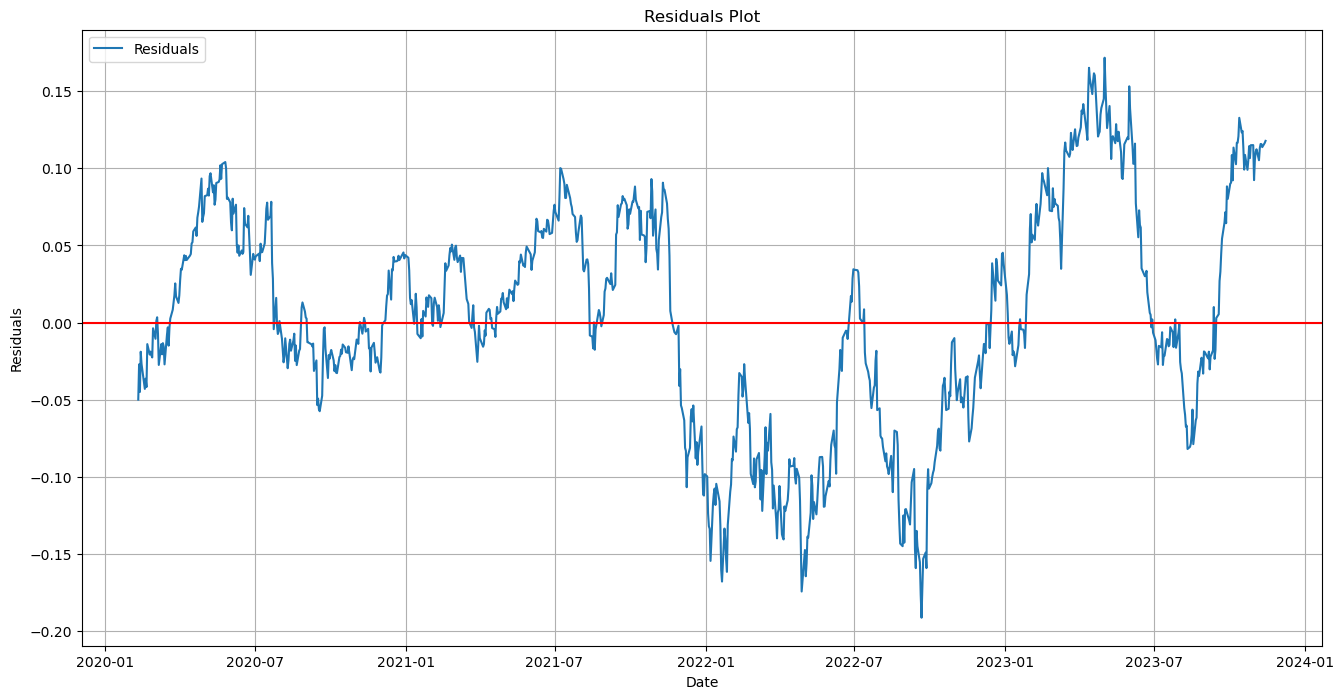

In [14]:
residuals = y_test - predictions.flatten()

# Plot the residuals
plt.figure(figsize=(16, 8))
plt.plot(last_close_values_test, residuals, label='Residuals')
plt.axhline(y=0, color='r')
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [61]:
# Calculate evaluation metrics using scaled values
mae = mean_absolute_error(y_test, predictions.flatten())
mse = mean_squared_error(y_test, predictions.flatten())
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 0.058070417690211214
Mean Squared Error (MSE): 0.0052111708725393925
Root Mean Squared Error (RMSE): 0.07218844002012643


 # Generate Additional Predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

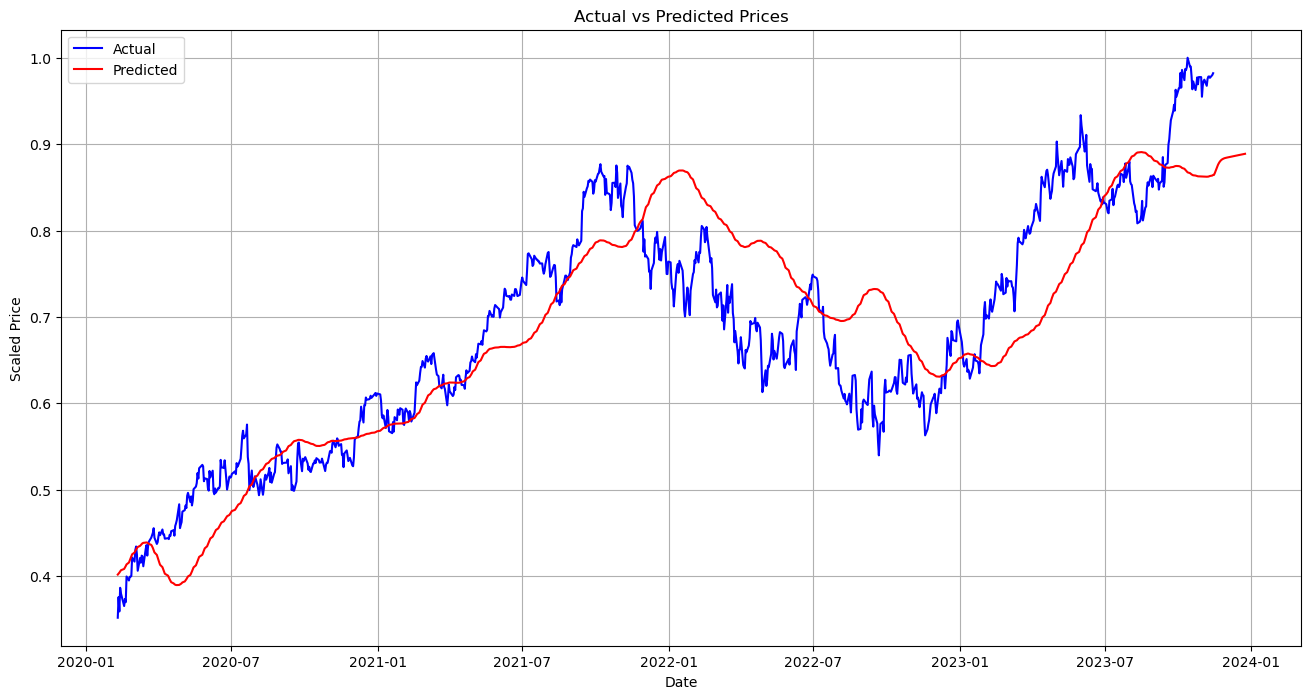

In [55]:
# Generate predicted dates
predicted_dates = pd.DatetimeIndex(last_close_values_test + pd.Timedelta(days=0))

# Rolling forecast function
def rolling_forecast(model, last_sequence, n_steps):
    predictions = []
    current_sequence = last_sequence.copy()
    for _ in range(n_steps):
        predicted_value = model.predict(current_sequence)[0][0]
        predictions.append(predicted_value)
        current_sequence = np.concatenate([current_sequence[:, 1:, :], np.repeat(predicted_value, current_sequence.shape[2]).reshape(1, 1, -1)], axis=1)
    return predictions

# Get the last sequence from test data
last_sequence = X_test[-1][np.newaxis, ...]

# Generate extended predictions
extended_predictions = rolling_forecast(model, last_sequence, n_steps=40)

# Generate extended dates
extended_dates = pd.date_range(start=last_close_values_test[-1] + pd.Timedelta(days=1), periods=len(extended_predictions), freq='D')

# Combine predictions and dates
all_predicted_dates = pd.DatetimeIndex(list(predicted_dates) + list(extended_dates))
all_predictions = np.concatenate([predictions.flatten(), extended_predictions])

# Plot results
plt.figure(figsize=(16, 8))
plt.plot(last_close_values_test, y_test, label='Actual', color='blue')
plt.plot(all_predicted_dates, all_predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.title('Actual vs Predicted Prices')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
